# **Imports**

In [9]:
from IPython.core.display import display, HTML
from scipy import stats as ss
import pandas     as pd
import inflection
import numpy      as np 
import seaborn    as sns
import matplotlib as plt 
import datetime


#CARREGANDO DADOS

#criando as bases de dados 
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#unindo as bases de dados 
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## **Import DEFs**

In [10]:
def cramer_v(x, y):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max( 0, chi2 - ( (k-1)*(r-1)/(n-1) ) )
    
    kcorr = k - (k-1) **2/(n-1)
    rcorr = r - (r-1) **2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
        
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [11]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\andre.vitorino\Anaconda3\envs\DataScienceEmProducao\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# **DESCRIÇÃO DOS DADOS**

In [12]:
#criando uma cópia da base original para poder trabalhar em cima dela 
df1 = df_raw.copy()

#verificando o nome das colunas 
df1.columns

#RENOMEANDO COLUNAS  

#armazenando as colunas em uma variável 
columns_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']


#alterando o formato dos nomes das colunas 
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,columns_old))
df1.columns = cols_new

In [13]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## **DIMENSÃO DOS DADOS**

In [14]:
#verificando as dimensões do dataframe
print('Numbers of rows: {}'.format(df1.shape[0]))
print('Numbers of columns: {}'.format(df1.shape[1]))

Numbers of rows: 1017209
Numbers of columns: 18


## **TIPO DOS DADOS**

In [15]:
#verificando os formatos das colunas 
df1.dtypes
#alterando o tipo da coluna 'date' para o formato datetime
df1['date'] = pd.to_datetime(df1['date'])

#VERIFICANDO NAs

#verificando a quantidade de NAs por coluna 
df1.isna().sum()

#PREENCHENDO NAs

#tratando as colunas com valores vazios
#competition_distance
df1['competition_distance'].fillna(200000.0, inplace=True)

#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 
''''for n in range(len(df1)):
    if str(df1['competition_open_since_month'][n]) == 'nan':
        df1['competition_open_since_month'][n] = df1['date'][n].month'''

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)  
'''for n in range(len(df1)):
    if str(df1['competition_open_since_year'][n]) == 'nan':
        df1['competition_open_since_year'][n] = df1['date'][n].year'''
    
#promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1) 
'''for n in range(len(df1)):
    if str(df1['promo2_since_week'][n]) == 'nan':
        df1['promo2_since_week'][n] = df1['date'][n].week'''
          
#promo2_since_year  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1) 
'''for n in range(len(df1)):
    if str(df1['promo2_since_year'][n]) == 'nan':
        df1['promo2_since_year'][n] = df1['date'][n].year'''

#promo_interval   
df1['promo_interval'].fillna(0, inplace=True)           


#gerando nova coluna no df 
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

#criando uma nova coluna no df 
df1['month_map'] = df1['date'].dt.month.map(month_map)

#criando uma nova coluna no df
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

''''for n in range(len(df1)):
    if df1['month_map'][n] in str(df1['promo_interval'][n]):
        df1['is_promo'][n] = 1
        #print('Está na promoção!!')
    else:
        df1['is_promo'][n] = 0 
        #print('Não está na promoção')'''

"'for n in range(len(df1)):\n    if df1['month_map'][n] in str(df1['promo_interval'][n]):\n        df1['is_promo'][n] = 1\n        #print('Está na promoção!!')\n    else:\n        df1['is_promo'][n] = 0 \n        #print('Não está na promoção')"

In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## **ALTERANDO TIPOS**  

In [17]:
#verificando o tipo das colunas
df1.dtypes

#alterando as colunas para o tipo INT
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)     
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int) 
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int) 

# **DESCRIÇÃO ESTATISTICA**

In [18]:
#criando variavel com somente atributos numéricos
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

#criando variavel com somente atributos categoricos 
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## **ATRIBUTOS NUMÉRICOS**

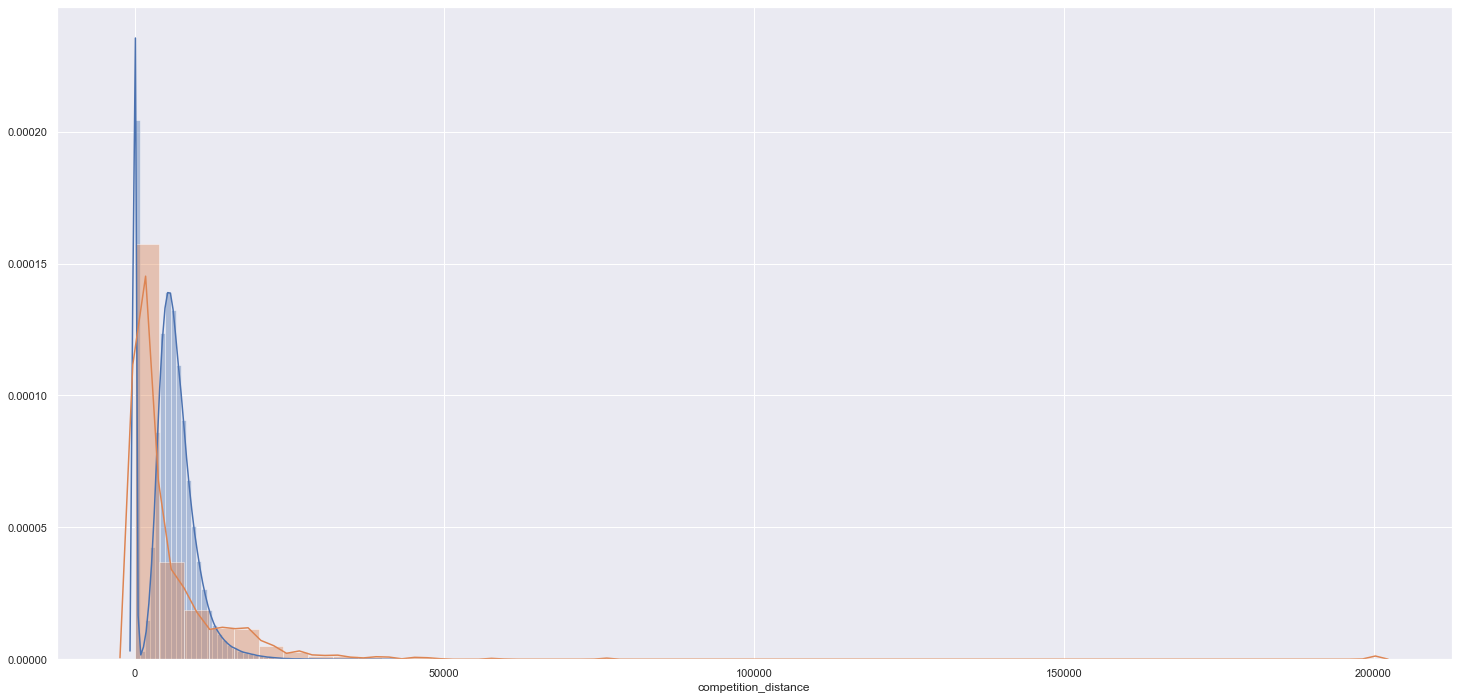

In [19]:
#central tendency - mean, median 
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
        
#dispersion - std, min, max, range, skew, kurtosis     
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T        
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T        
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T        
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

#plotando a coluna sales 
sns.distplot(df1['sales'])
sns.distplot(df1['competition_distance'])

## **ATRIBUTOS CATEGÓRICOS**

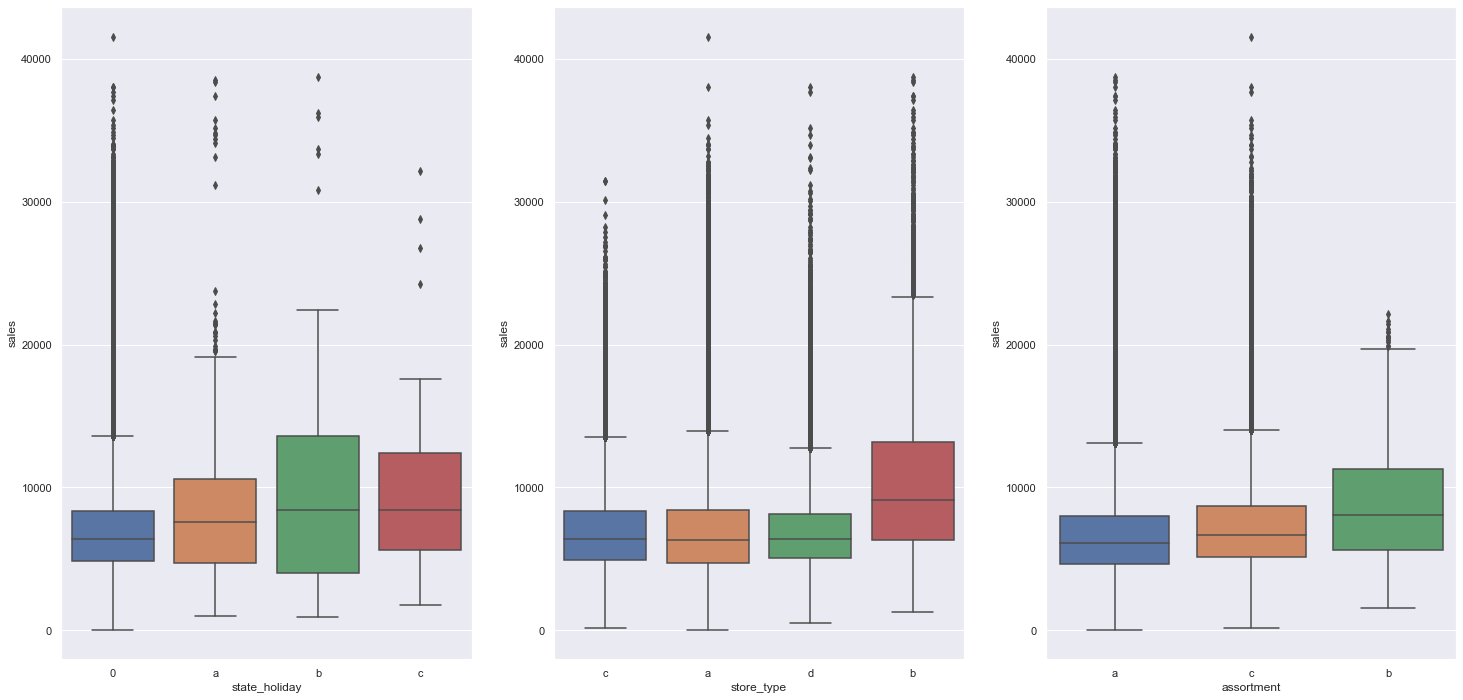

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

#criando variavel com valores diferentes de 0 
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

#fazendo a plotagem para detecção de outliers 
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1 )

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1 )

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1 )

In [21]:
#criando uma cópia do data frame, para ter um backup
df2 = df1.copy()

#fazendo a criação de novas variáveis 
#year 
df2['year'] = df2['date'].dt.year

#month 
df2['month'] = df2['date'].dt.month

#day 
df2['day'] = df2['date'].dt.day

#week of year 
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week 
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since 
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] ) /30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment 
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#mesma forma de fazer o código acima, com a diferença que com 7M(ou mais) de linhas no DF a linha de cima desempenha melhor 
'''for n in range(len(df2)):
    if df2['assortment'][n] == 'a':
        df2['assortment'][n] = 'basic'
        
    if df2['assortment'][n] == 'b':
        df2['assortment'][n] = 'extra'
        
    else:
        df2['assortment'][n] = 'extended'''
        

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

#mesma forma de fazer o código acima, com a diferença que com 7M(ou mais) de linhas no DF a linha de cima desempenha melhor 
'''for n in range(len(df2)):
    if df2['assortment'][n] == 'a':
        df2['assortment'][n] = 'public_holiday'
        
    if df2['assortment'][n] == 'b':
        df2['assortment'][n] = 'easter_holiday'
        
    if df2['assortment'][n] == 'c':
        df2['assortment'][n] = 'christmas'
        
    else:
        df2['assortment'][n] = 'regular_day'''

"for n in range(len(df2)):\n    if df2['assortment'][n] == 'a':\n        df2['assortment'][n] = 'public_holiday'\n        \n    if df2['assortment'][n] == 'b':\n        df2['assortment'][n] = 'easter_holiday'\n        \n    if df2['assortment'][n] == 'c':\n        df2['assortment'][n] = 'christmas'\n        \n    else:\n        df2['assortment'][n] = 'regular_day"

## **FILTAGREM DE VARIAVEIS**

In [22]:
#criando uma cópia do data frame, para ter um backup
df3 = df2.copy()

#FILTRAGEM DE LINHAS 
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

cols_drop = df3.drop(cols_drop, axis=1)

# **4.0 ANALISE EXPLORATÓRIA DE DADOS**

## **ANALISE UNIVARIADA**

In [23]:
df4 = df3.copy()

## **VARIAVEL RESPOSTA**

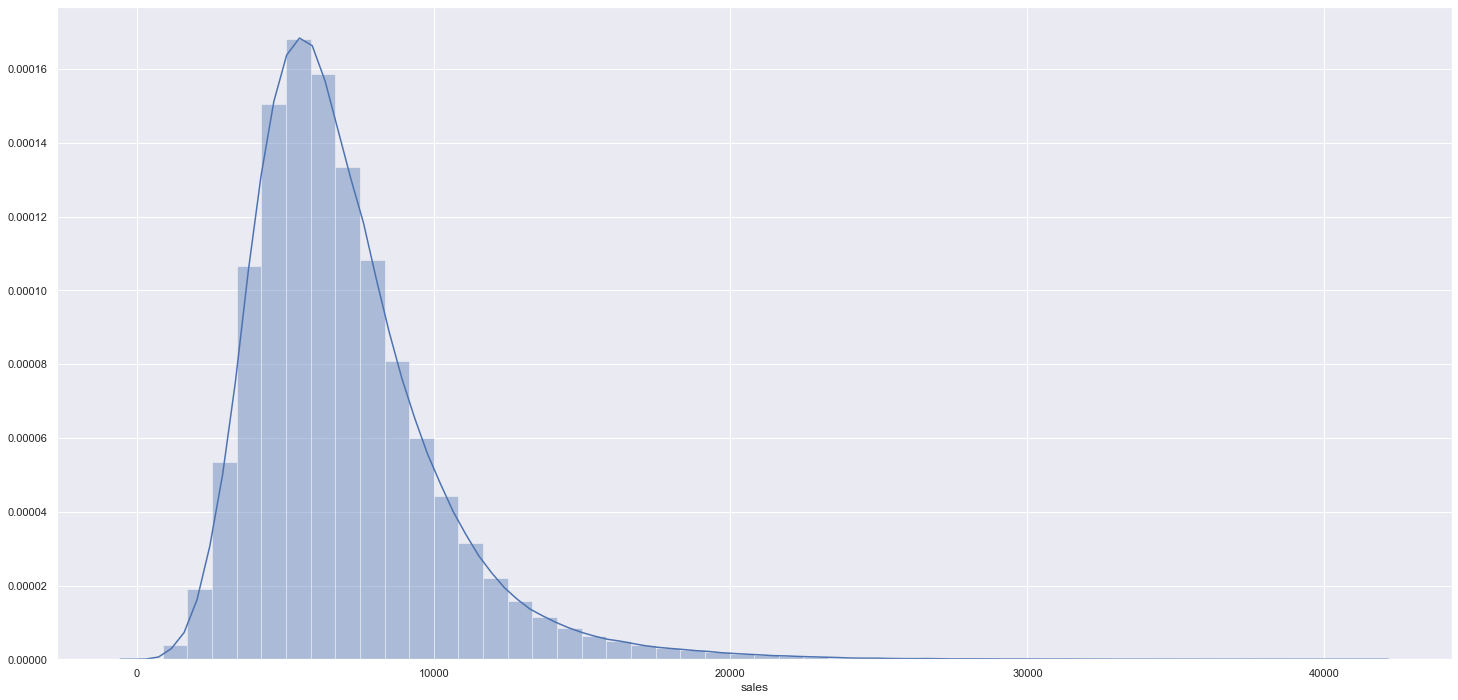

In [24]:
#Plotando a distribuição dos dados das vendas 
sns.distplot(df4['sales']);

#para gerar apenas o histograma 
#sns.distplot(df4['sales'], kde=False)

#método para aplicar o skew para o lado direito 
#sns.distplot(np.log1p((df4['sales'])))

## **VARIÁVEIS NUMÉRICAS**

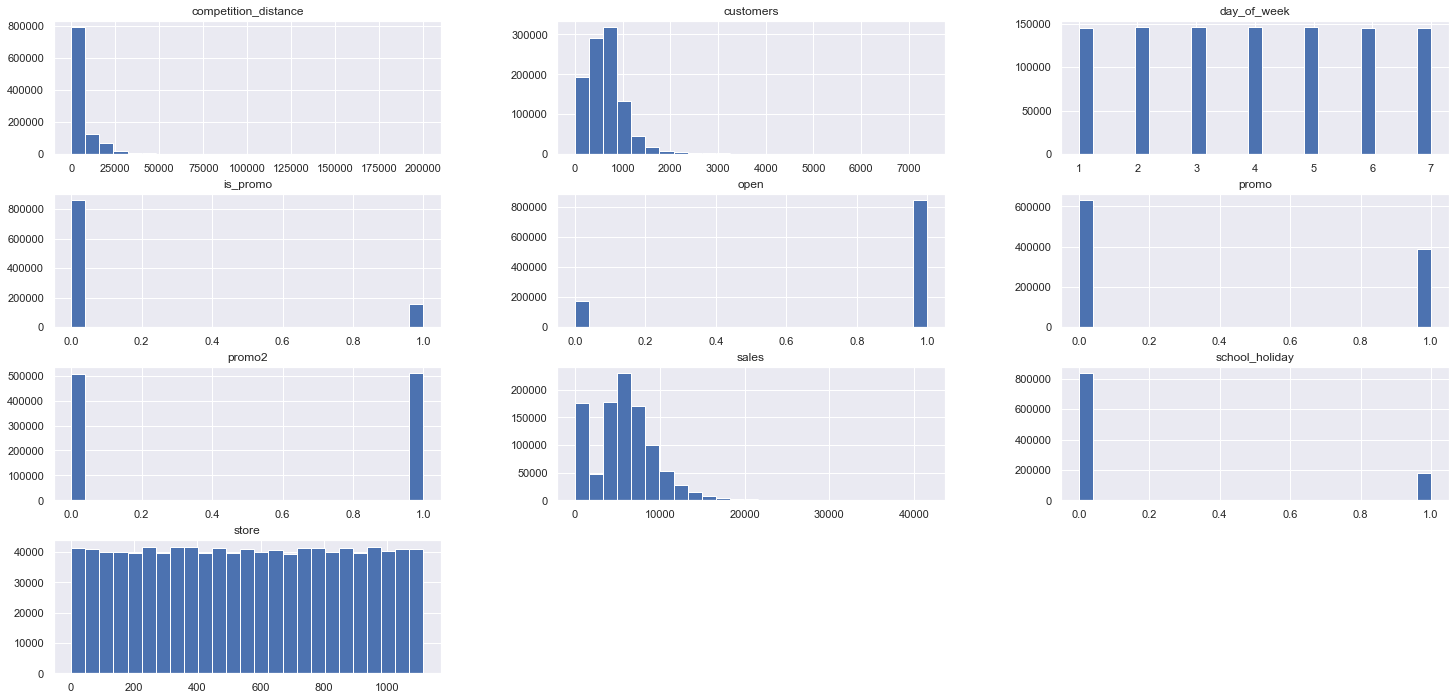

In [25]:
#plotando todos os gráficas da variável numérica 
num_attributes.hist(bins=25);

## **VARIÁVEIS CATEGÓRICAS**

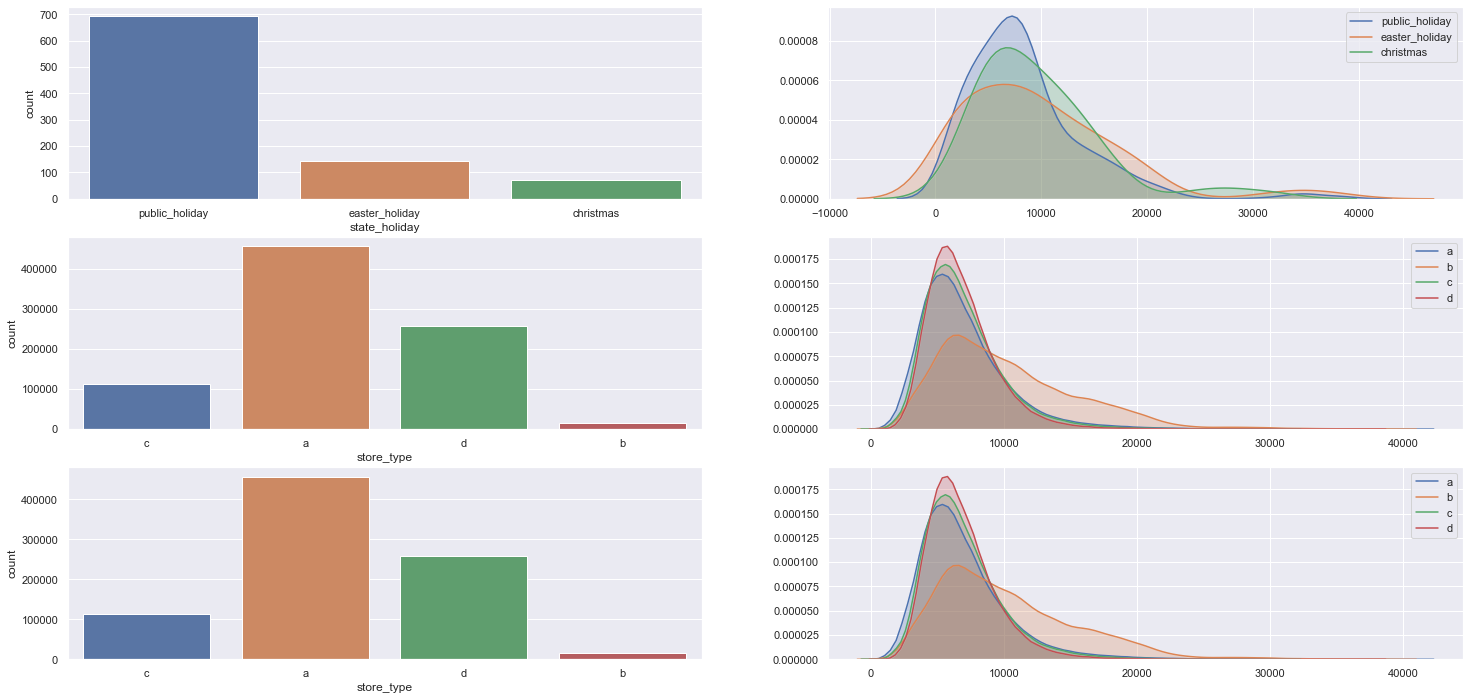

In [26]:
#Analisando os 5 primeiros atributos categóricos
cat_attributes.head()

#dropando as informações duplicadas 
df4['state_holiday'].drop_duplicates()

#state holiday
#usando comando para plottar mais de um gráfico 
#3 linhas, 2 colunas, grafico 1
plt.subplot(3,2,1)

#filtrando state_holiday para tirar os dias normais 
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

#3 linhas, 2 colunas, grafico 2
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label='public_holiday', shade='True');
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'],label='easter_holiday', shade='True');
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],label='christmas', shade='True');


#store_type
#3 linhas, 2 colunas, grafico 3
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

#3 linhas, 2 colunas, grafico 4
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a', shade='True');
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b', shade='True');
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c', shade='True');
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d', shade='True');

#assortment
#3 linhas, 2 colunas, grafico 5
plt.subplot(3,2,5)
sns.countplot(df4['store_type']);

#3 linhas, 2 colunas, grafico 6
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a', shade='True');
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b', shade='True');
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c', shade='True');
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d', shade='True');


# 4.2 ANALISE BIVARIADA

### **H1.** Lojas com maior sortimento deveriam vender mais.
**Falsa:** Lojas com maior sortimento vendem menos

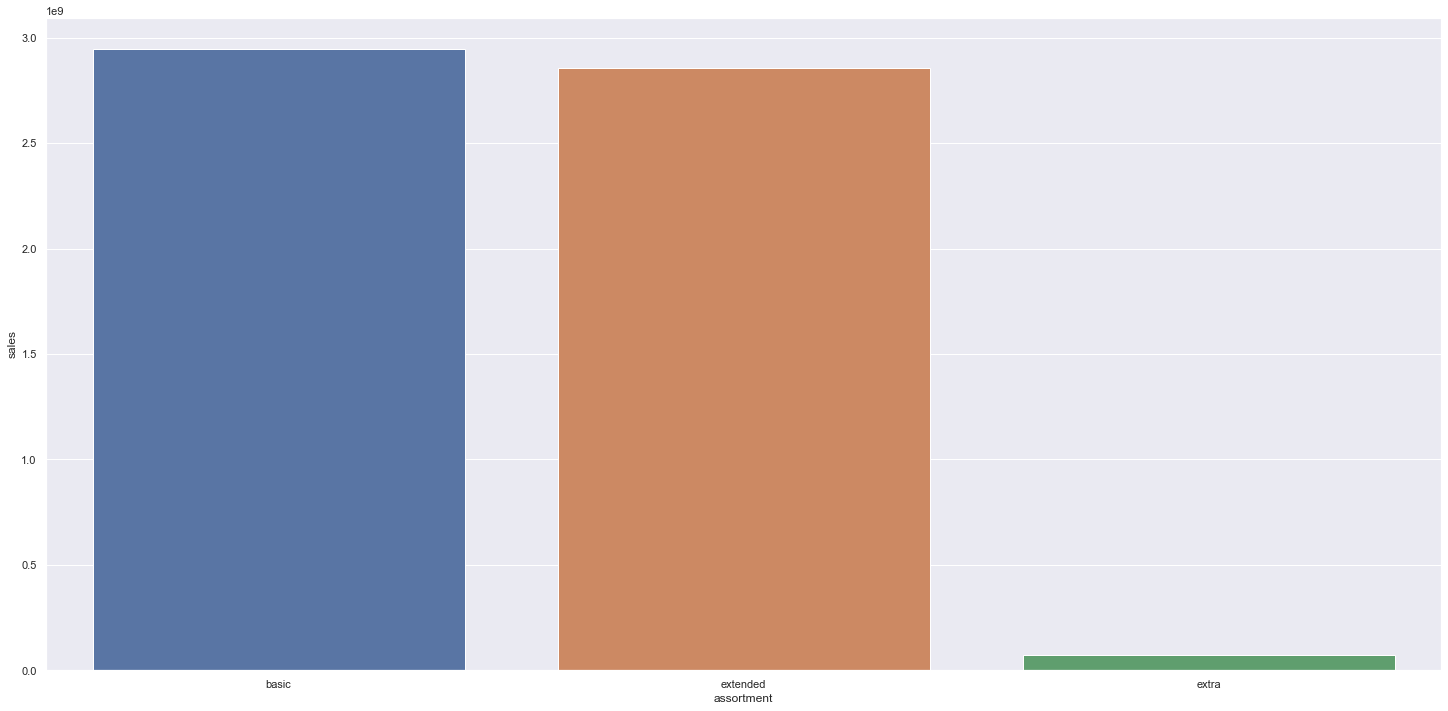

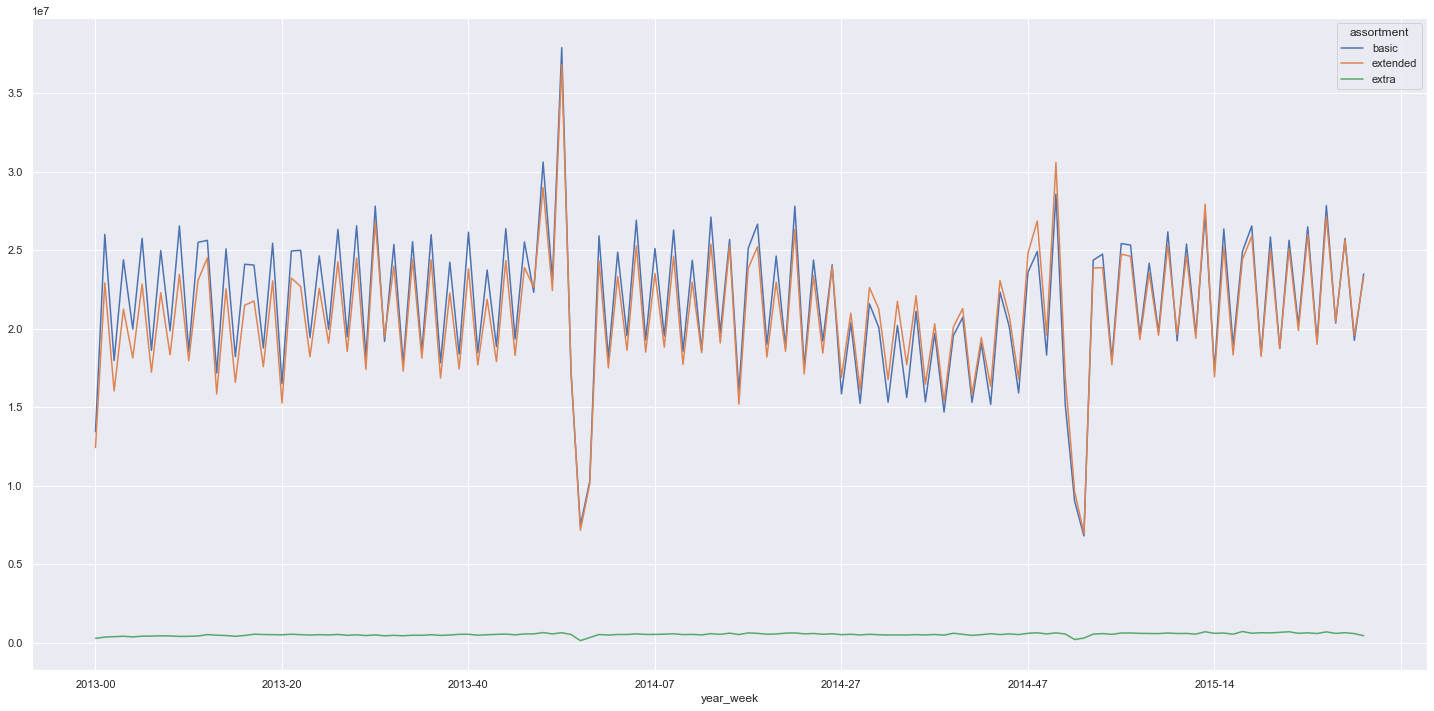

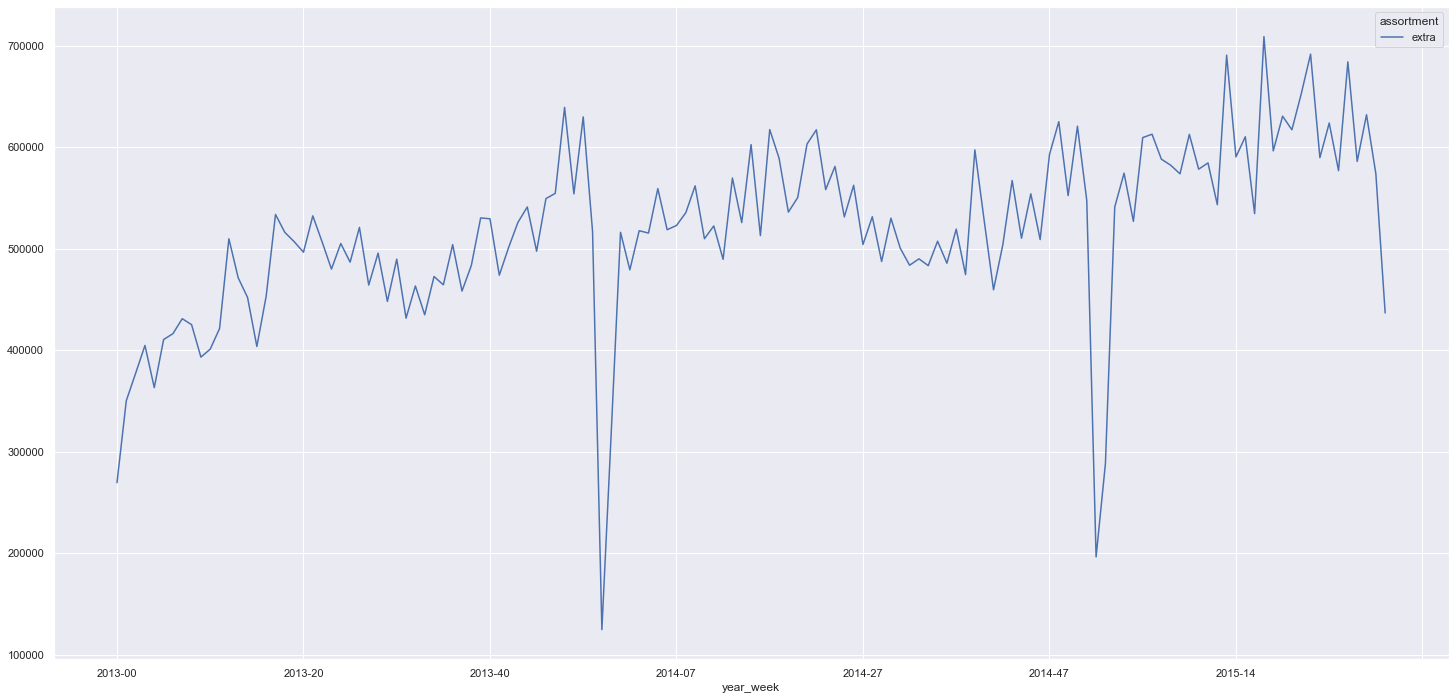

In [27]:
#agrupando todas as vendas por assortment 
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
#plotando o gráfico com as vendas por assortment 
sns.barplot(x='assortment', y='sales', data=aux1);

#agrupando todas as vendas por assortment e semanas do ano 
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
#fazendo a plotagem do gráfico com as vendas por assortment pelas semanas do ano 
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

#filtrando as vendas somente pelo assortment extra
aux3 = aux2[aux2['assortment'] == 'extra']
#criando um pivot para inverter as informações
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

## **H2.** Lojas com competidores mais próximos vendem menos.
**Falso** Lojas com competidores mais próximos vendem mais 

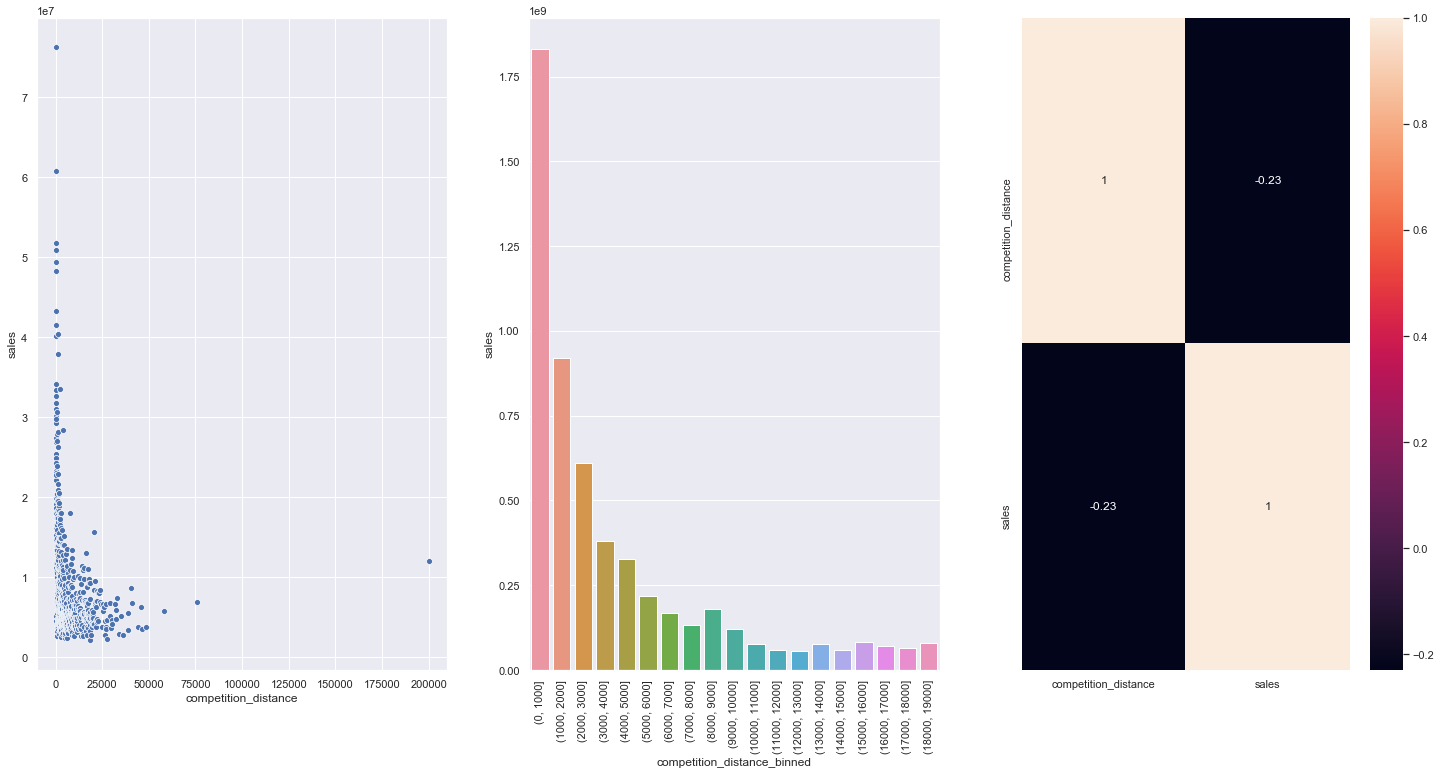

In [28]:
#agrupando todas as vendas pela distancia dos outros competidores até a nossa loja 
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

#criando um conjunto de gráficos, com 1 linha e e 3 colunas 
#gráfico na posição 1 
plt.subplot(1,3,1)
#plotagem usando os pontos para visualizar melhor o comportamento dos dados
#o ';' no final da linha serve para evitar as mensagens de plottagem  
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

#gráfico na posição 2 
plt.subplot(1,3,2)
#criando grupos de 1k em 1k até 20k para agrupar as lojas de 1000 em mil metros em um único grupo 
bins = list(np.arange(0, 20000, 1000))
#aplicando os grupos de 1k em 1k na variavel 'competition_distance_binned'
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
#agrupando as vendas pela distancia da loja 
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
#fazendo a plotagem do gráfico com os grupos de 1k em 1k 
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
#rodando as legendas do eixo 'x' para melhor visualização 
plt.xticks(rotation = 90);

#gráfico na posição 3
plt.subplot(1,3,3)
#criando um heatmap para verificar a correlação entre a distancia e a quantidade de vendas 
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H3.** Lojas com competidores a mais tempo vendem mais 
**Falsa:** Lojas com competidores a mais tempo vendem menos

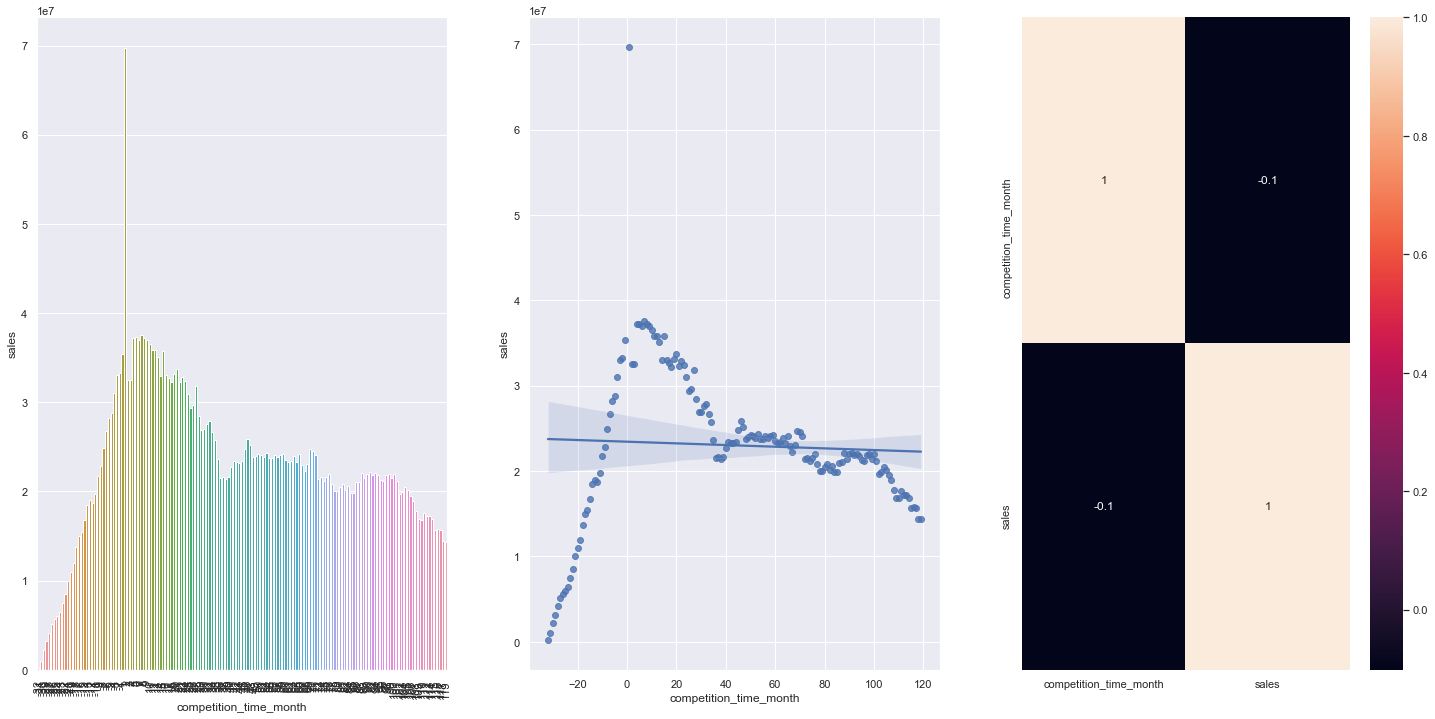

In [29]:
#criando lista com 1 linha 3 3 colunas 
#plot na posição 1 
plt.subplot(1,3,1)

#verificando a quantidade de vendas por meses 
#criando filtro de vendas por meses desde a abertura das lojas proximas 
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
#fazendo filtro com lojas com menos de 120 meses desde a abertura de outras lojas 
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
#fazendo a plotagem com a variavel filtrada 
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

#plot na posição 2
plt.subplot(1,3,2)

#fazendo a plotagem da tendência dos dados
sns.regplot(x='competition_time_month', y='sales', data=aux2);

#posição 3 
plt.subplot(1,3,3)
#gerando heatmap
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa:** Lojas com promoções a mais tempo vendem menos, depois de um certo período 

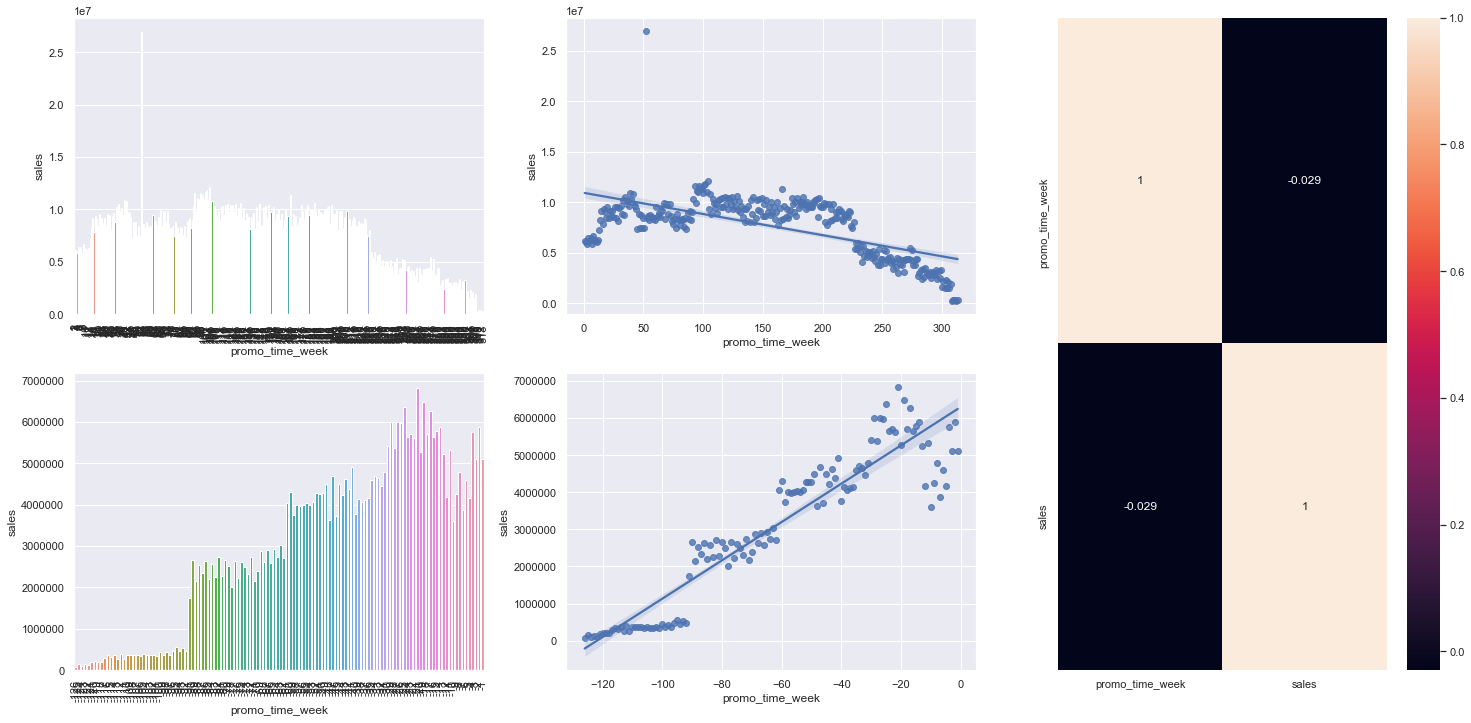

In [30]:
#gerando variavel para comparação das colunas 
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

#criando um 'subplot' unindo as duas linhas da última coluna para ser usado como um gráfico só 
grid = GridSpec(2, 3)

#linha 0 coluna 0
plt.subplot(grid[0,0])

#filtrando a promoção como 'promoção extendida'
aux2 = aux1[aux1['promo_time_week'] > 0] #promoção extendida
#plotando o gráfico de promoções extendidas 
sns.barplot(x='promo_time_week', y='sales', data=aux2);
#girando as legendas em 90 graus 
plt.xticks(rotation=90);

#coluna 0 linha 1 
plt.subplot(grid[0,1])
#plotando o gráfico da têndencia de vendas do primeiro gráfico 
sns.regplot(x='promo_time_week', y='sales',data=aux2);

#coluna 1 linha 0 
plt.subplot(grid[1,0])

#filtrando a promoção por 'promoção normal '
aux3 = aux1[aux1['promo_time_week'] < 0] #promoção normal

#plotandoo o gráfico de vendas durante a promoção normal 
sns.barplot(x='promo_time_week', y='sales', data=aux3);
#girando as legendas em 90 graus
plt.xticks(rotation=90);

#coluna 1 linha 1 
plt.subplot(grid[1,1])
#plotando o gráfico da têndencia de vendas do segundo gráfico 
sns.regplot(x='promo_time_week', y='sales', data=aux3);

#todas as linhas da última coluna
plt.subplot(grid[:,2])
#plotando o heatmap da variavel 'aux1' para ver a correlação entre as variaveis 
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

<s> **H5.** Lojas com mais dias de promoção deveriam vender mais</s>

## **H6.** Lojas com promoções consecutivas vendem mais 
**Falsa:** Lojas com promoções consecutivas vendem menos 

In [31]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


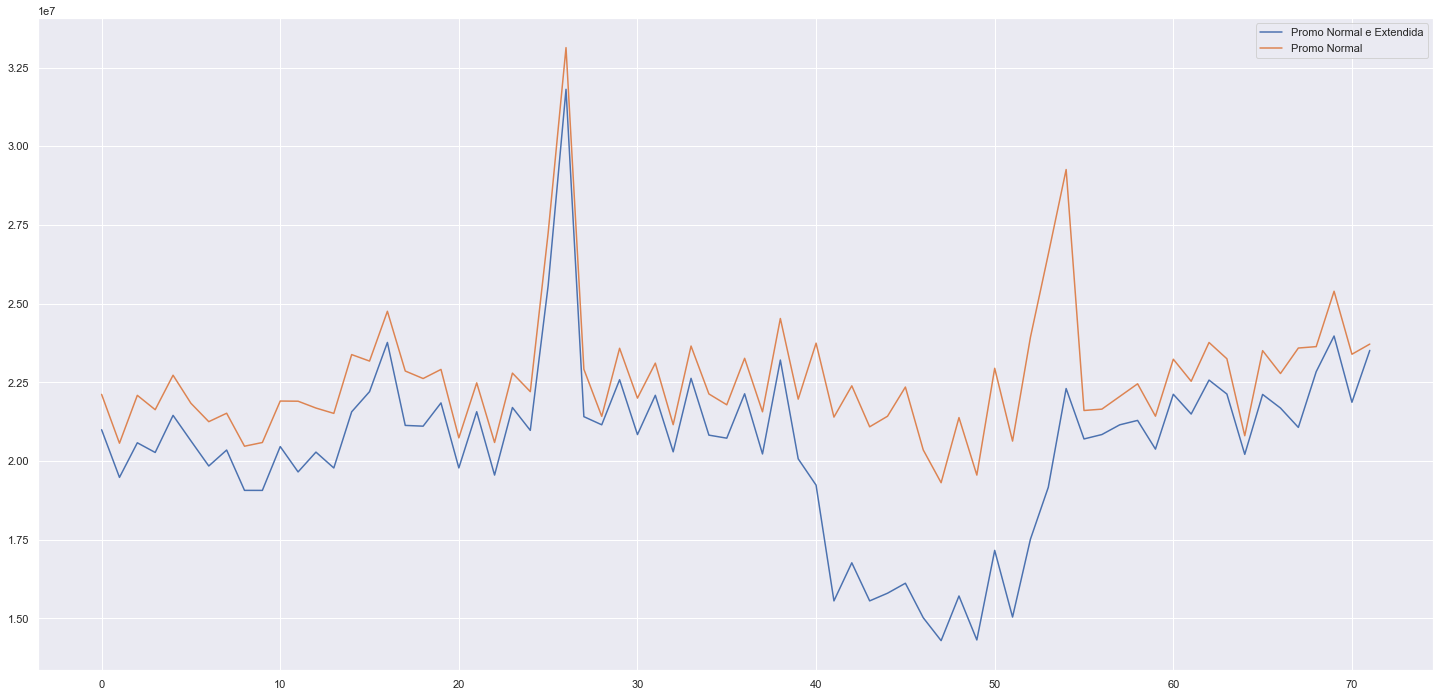

In [32]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);
plt.legend(['Promo Normal e Extendida', 'Promo Normal']);

## **H8.** Lojas abertas durante o feriado de natal deveriam vender mais. 
**Falsa:** Lojas abertas durante o feriado de natal não vendem mais 

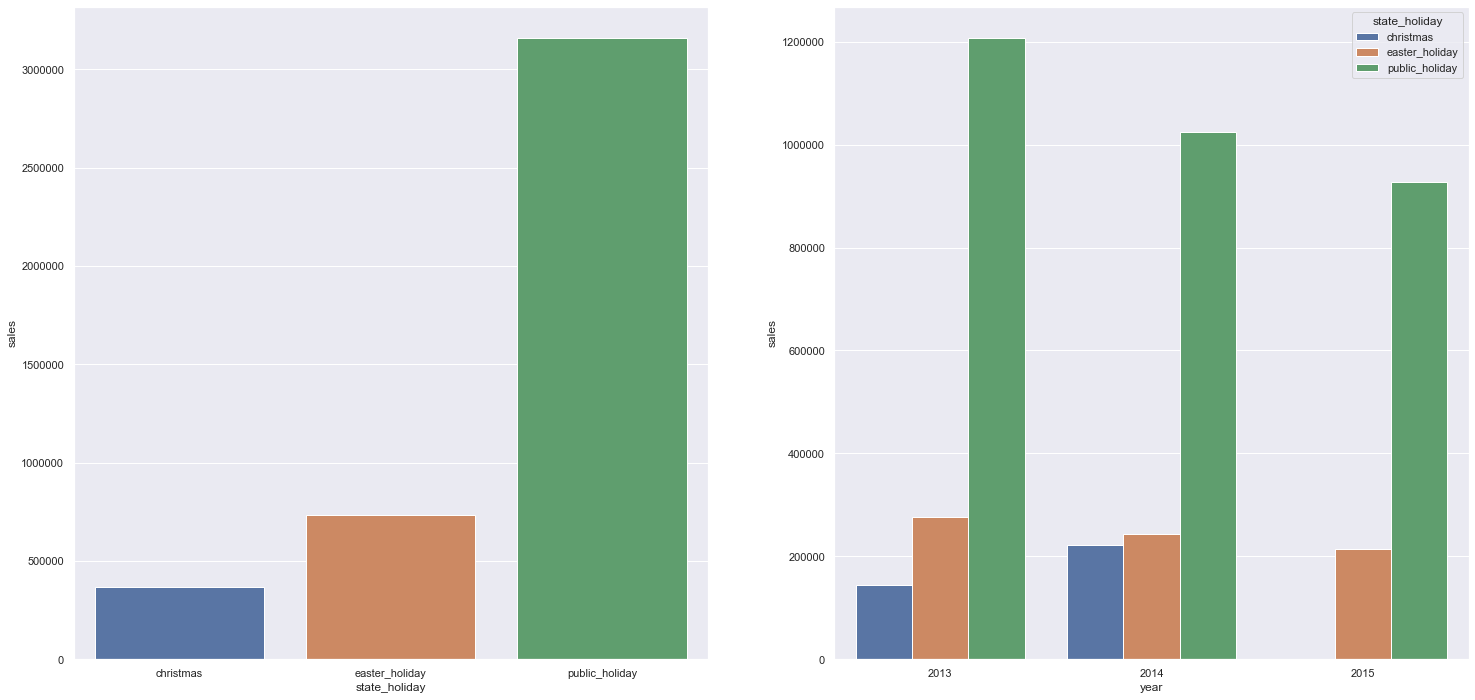

In [33]:
#criando filtro para tirar os dias regulares 
aux = df4[(df4['state_holiday'] != 'regular_day') & (df4['sales'])]

#linha 1 coluna 1  
plt.subplot(1,2,1)

#agrupando as vendas pelos feriados
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
#plotando gráfico de vendas por feriados 
sns.barplot(x='state_holiday', y='sales', data=aux1);

#linha 1 coluna 2
plt.subplot(1,2,2)

#agrupando as vendas por feriados através dos anos 
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
#plotando gráfico de vendas por feriados através dos anos 
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

## **H9.** Lojas deveriam vender mais ao longo dos anos 
**Falsa:** Lojas vendem menos ao longo dos anos 

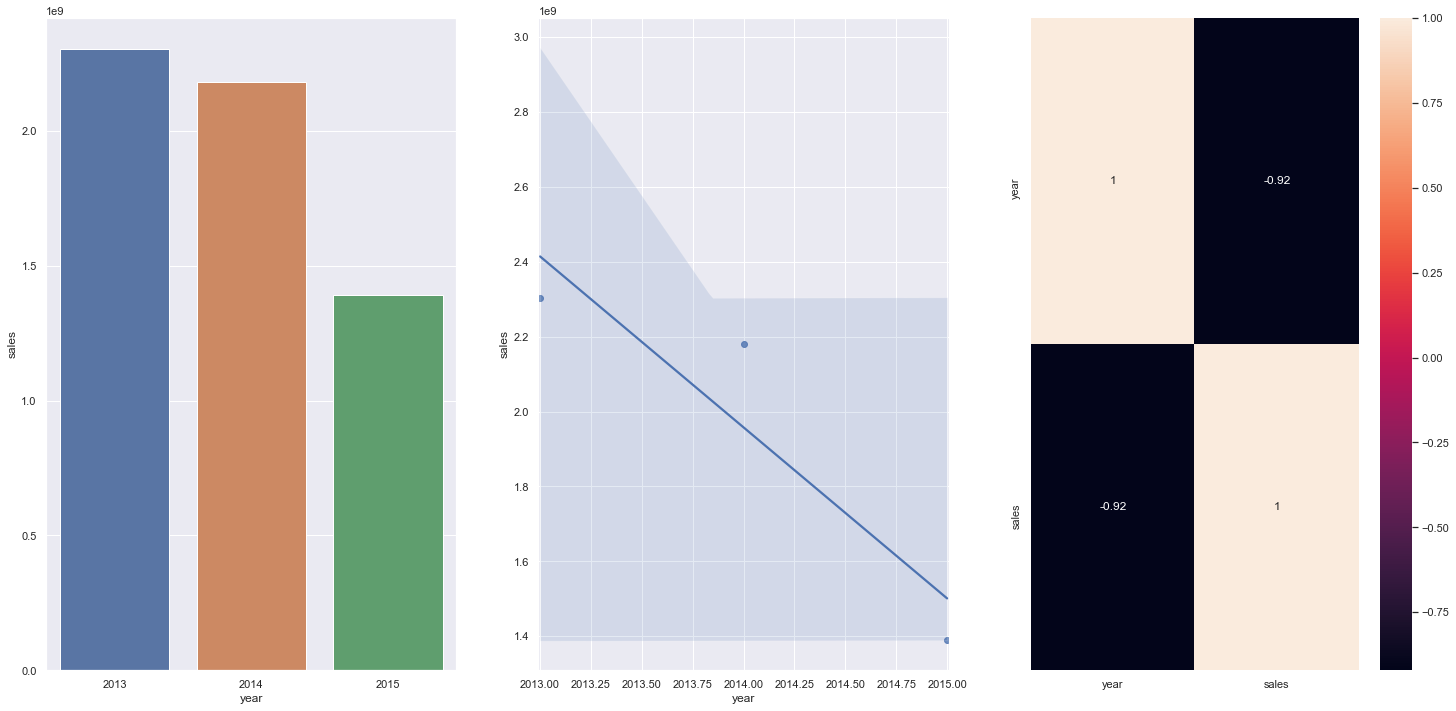

In [34]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H10.** Lojas deveriam vender mais no segundo semestre do ano
**Falsa:** As lojas vendem menos no segundo semestre do ano 

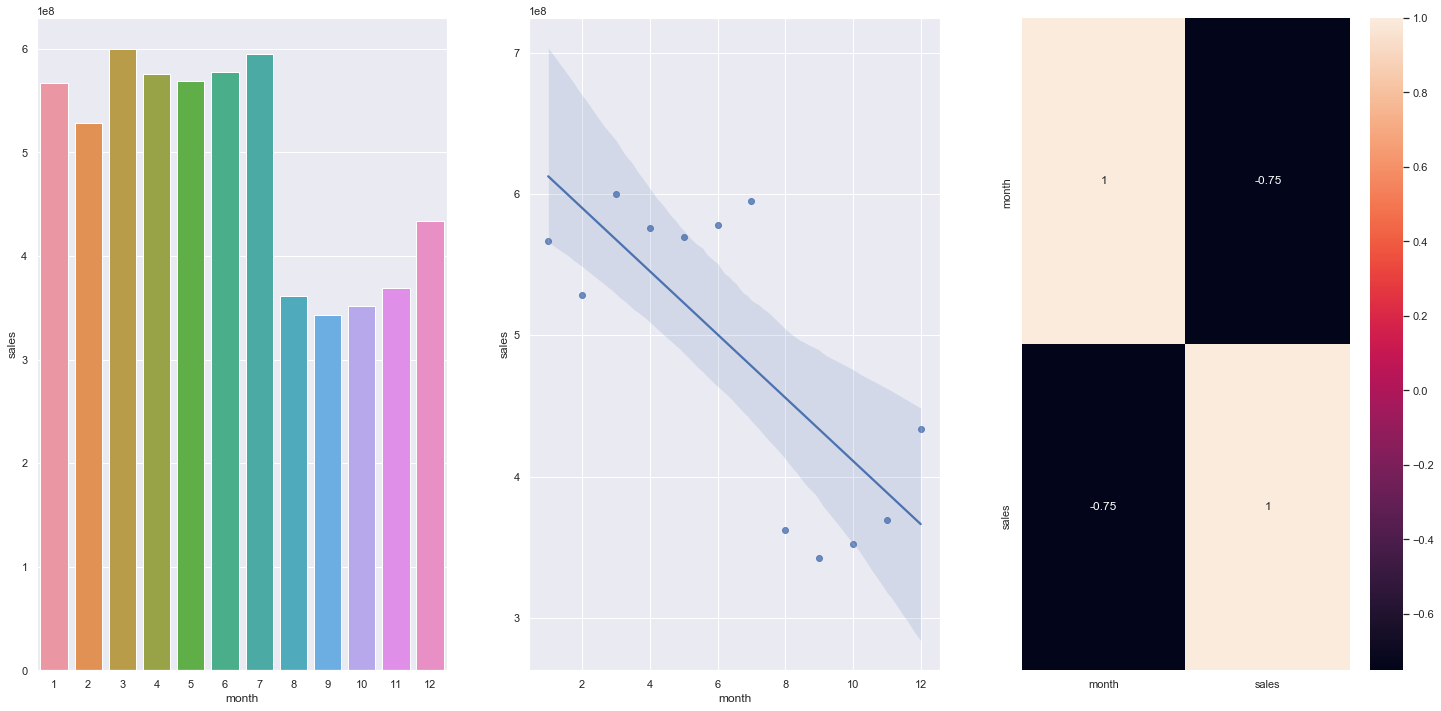

In [35]:
#criando variavel com as vendas por mês 
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

#linha 1, coluna 1, posição 1
plt.subplot(1,3,1)
#plotando as vendas por meses 
sns.barplot(x='month', y='sales', data=aux1);

#linha 1, coluna 1, posição 2
plt.subplot(1,3,2)
#plotando a tendência das vendas por meses 
sns.regplot(x='month', y='sales', data=aux1);

#linha 1, coluna 1, posição 3
plt.subplot(1,3,3)

#gerando a correlação entre as colunas da variavel 'aux1'
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês 
**Verdadeira:** As lojas vendem mais depois do dia 10 de cada mês 

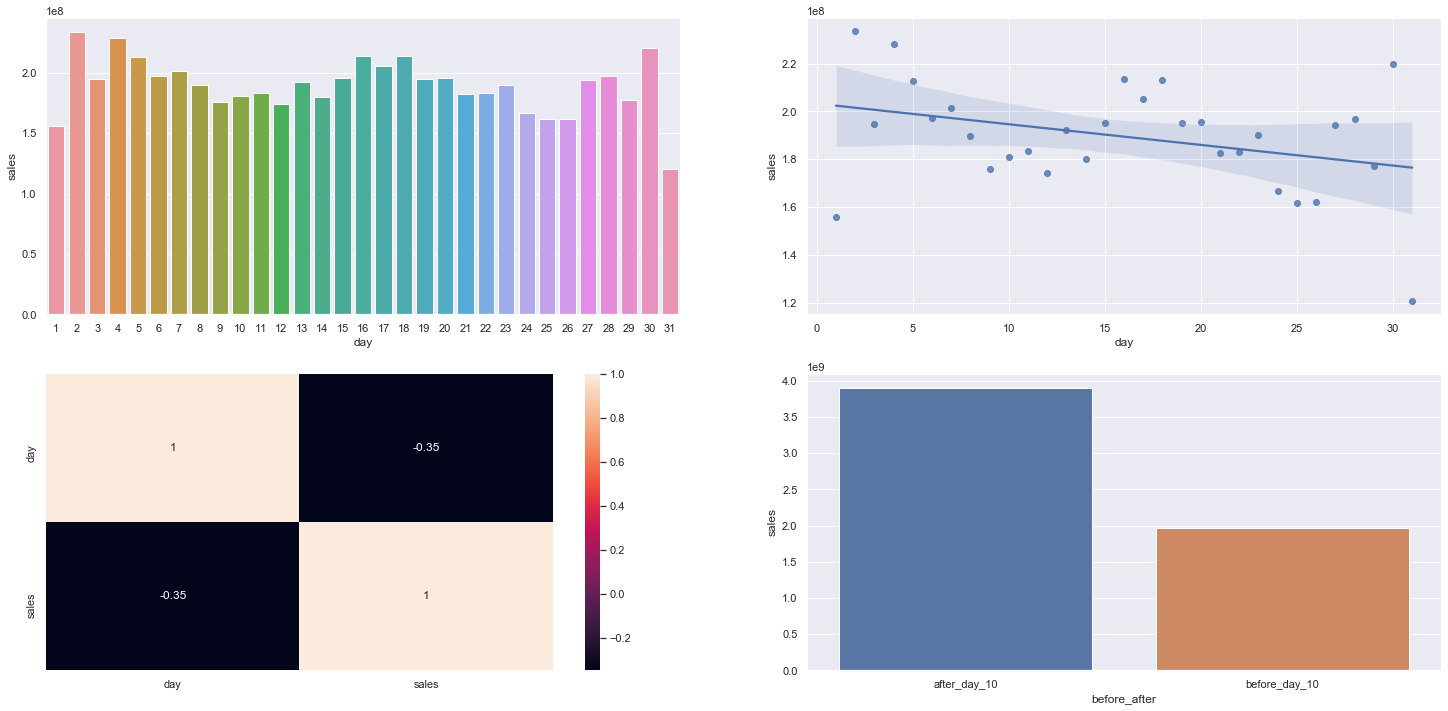

In [36]:
#criando variavel com as vendas por dias 
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

#linha 1, coluna 1
plt.subplot(2,2,1)
#plotando as vendas por dias 
sns.barplot(x='day', y='sales', data=aux1);

#linha 1, coluna 2
plt.subplot(2,2,2)
#plotando a tendência das vendas por dias 
sns.regplot(x='day', y='sales', data=aux1);

#linha 2, coluna 1
plt.subplot(2,2,3)

#gerando a correlação entre as colunas da variavel 'aux1'
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

#linha 2, coluna 2 
plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

## **H12.** Lojas deveriam vender menos ao finais de semana 
**Verdadeiro:** Lojas vendem menos aos finais de semana 

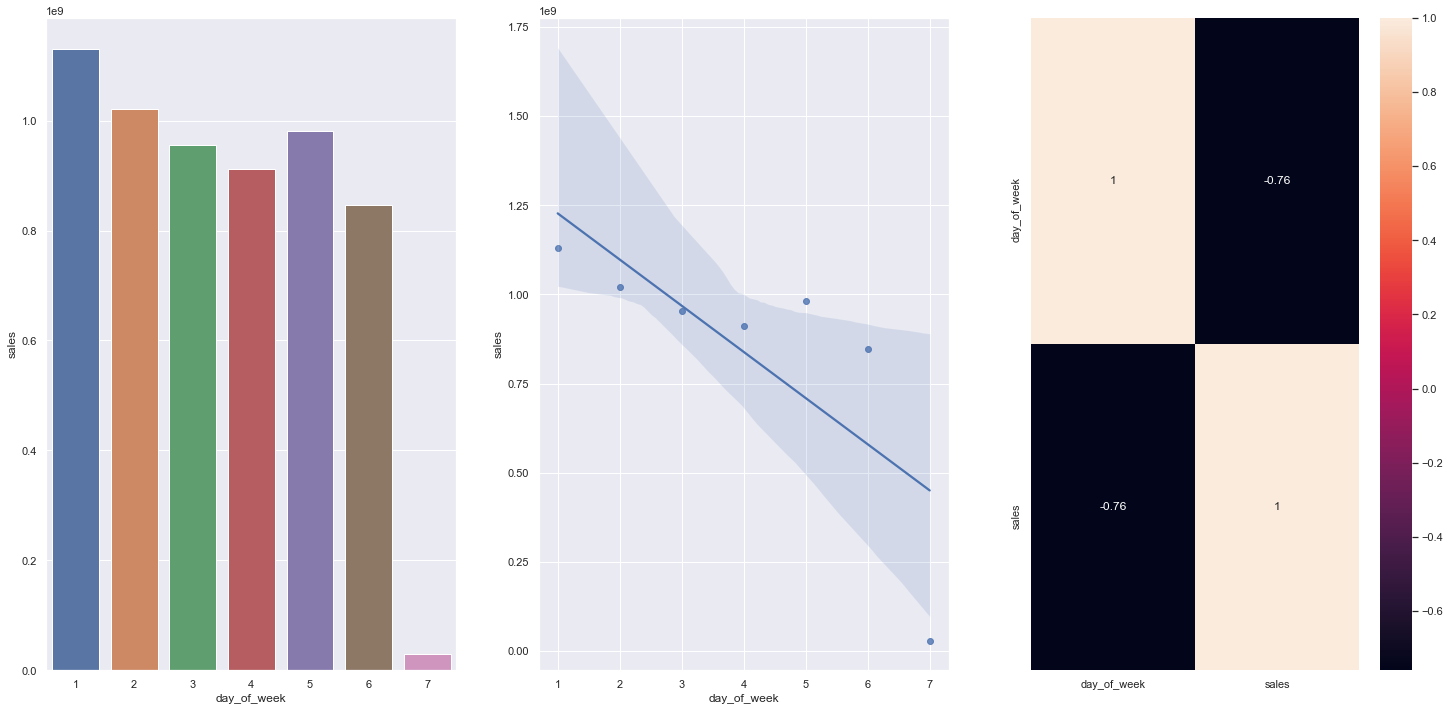

In [37]:
#criando variavel com as vendas por dias da semana  
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

#linha 1, coluna 1
plt.subplot(1,3,1)

#plotando as vendas por dias da semana 
sns.barplot(x='day_of_week', y='sales', data=aux1);

#linha 1, coluna 2
plt.subplot(1,3,2)

#plotando a tendência das vendas por dias da semana 
sns.regplot(x='day_of_week', y='sales', data=aux1);

#linha 1, coluna 3
plt.subplot(1,3,3)

#gerando a correlação entre as colunas da variavel 'aux1'
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

## **H13.** Lojas deveriam vender menos durante os feriados escolares
**Verdadeiro:** As lojas vendem menos durante os feriados escolares, com exceção do mês de agosto  

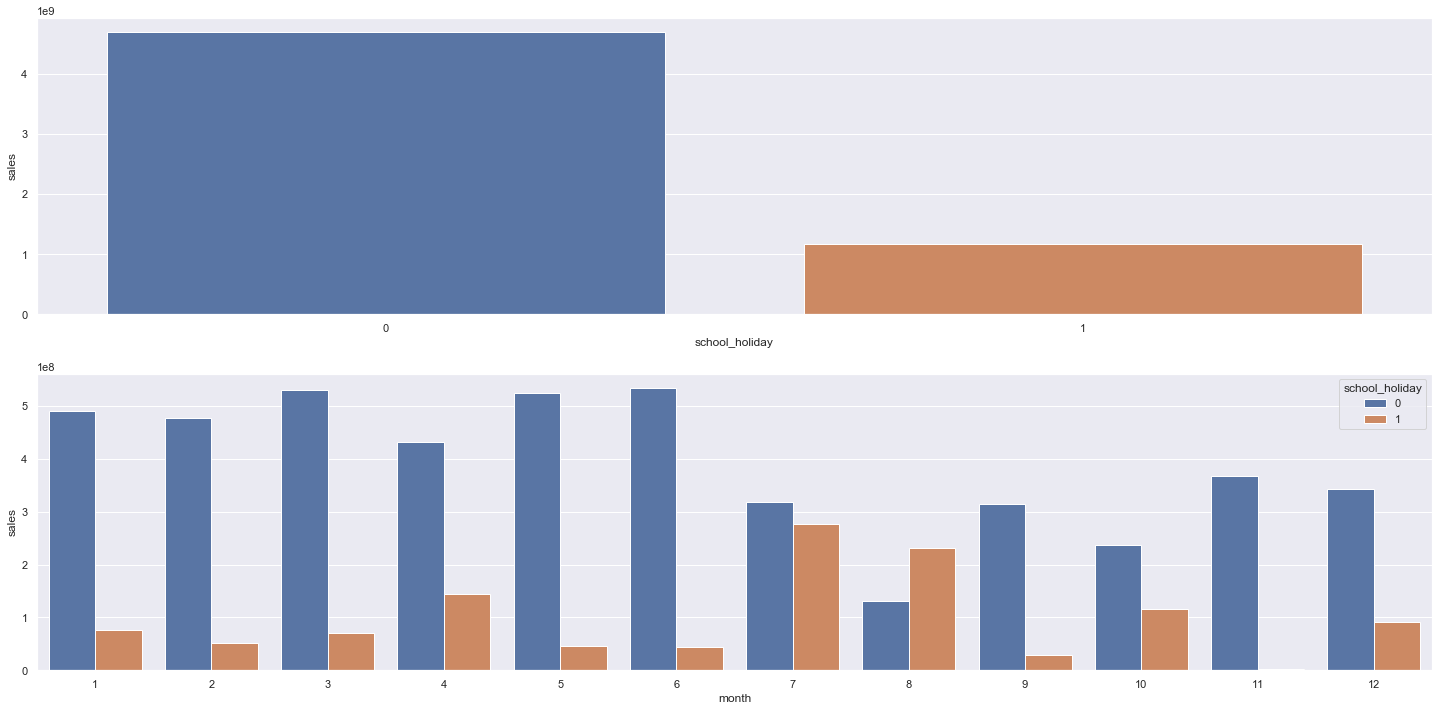

In [38]:
#criando variavel com as vendas por dias da semana  
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
#linha 1, coluna 1
plt.subplot(2,1,1)
#plotando as vendas por dias da semana 
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2);

# **ANALISE MULTIVARIADA**

## **ATRIBUTOS NUMERICOS**

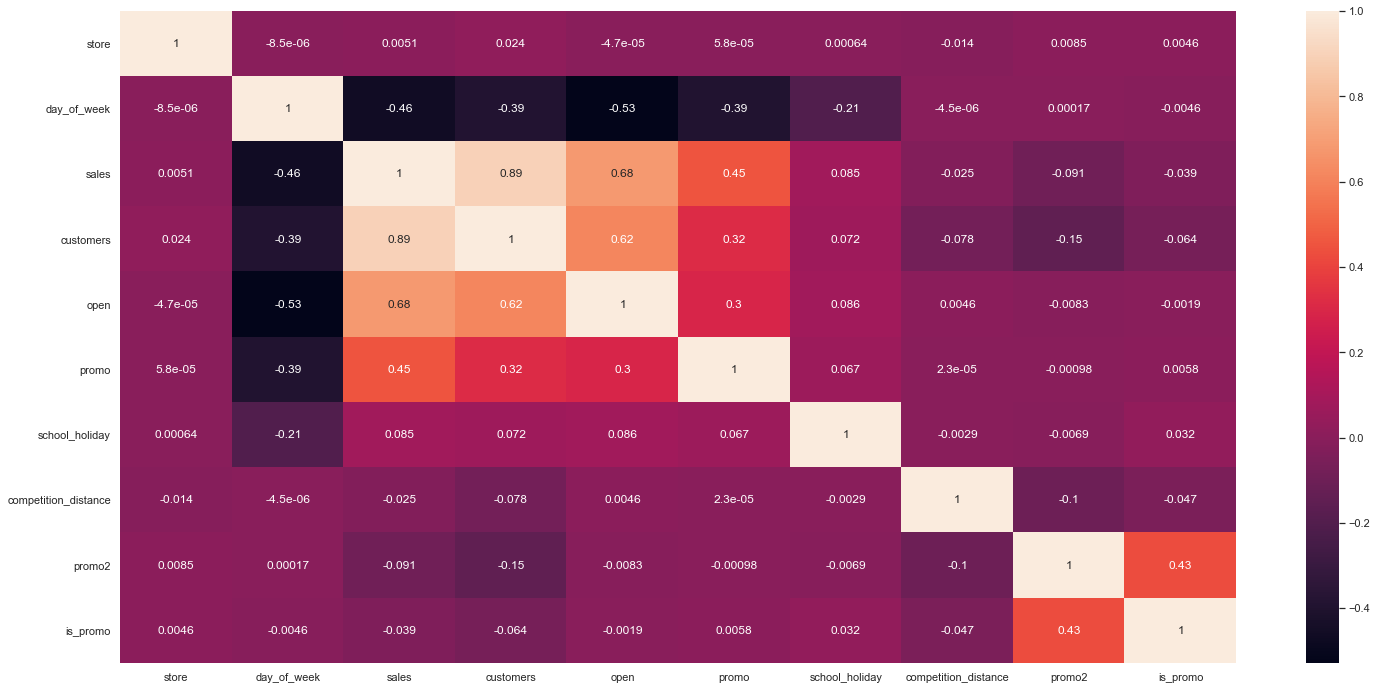

In [39]:
correlacao = num_attributes.corr(method='pearson')
sns.heatmap(correlacao, annot=True);

In [203]:
a = df4.select_dtypes(include='object')

In [221]:
a1 = cramer_v(a['state_holiday'] ,a['state_holiday'] )
a2 = cramer_v(a['state_holiday'] ,a['store_type'] )
a3 = cramer_v(a['state_holiday'] ,a['assortment'] )

a4 = cramer_v(a['store_type'] ,a['state_holiday'] )
a5 = cramer_v(a['store_type'] ,a['store_type'] )
a6 = cramer_v(a['store_type'] ,a['assortment'] )

a7 = cramer_v(a['assortment'] ,a['state_holiday'] )
a8 = cramer_v(a['assortment'] ,a['store_type'] )
a9 = cramer_v(a['assortment'] ,a['assortment'] )

df = pd.DataFrame({'state_holiday':[a1, a2, a3],
                   'store_type':[a4, a5, a6],
                   'assortment':[a7, a8, a9]})
df = df.set_index(df.columns)

In [222]:
df

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001
